In [ ]:
# !git clone https://github.com/zhangrh93/InvertibleCE $CODE_DIR

In [2]:
import sys
sys.path.append("..")
sys.path.append("/share/home/francesco/concept_composers/DeepComposerClassification/")
sys.path.append("/share/home/francesco/concept_composers/")
sys.path.append("..") #invertible ICE repo


# MNIST model with GlobalAveragePooling


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt  
import os
import torchvision
import numpy as np

import os
from pathlib import Path

# from torchsummary import summary
import shutil

import numpy as np

# from methods.activations import HandleActivations

from DeepComposerClassification.resnet import resnet50
from tcav.tcav_utils import assemble_concept, get_tensor_from_filename
from DeepComposerClassification.generator import Generator
from tools.data_loader import MIDIDataset

from config import concepts_path, splits_root
concepts_path = os.path.join(concepts_path, 'npy')

device = "cuda:3" ## TODO: import or configure (also used in trainer)

import random
import pandas as pd

seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

## Model structure
Let's load the composer classification model

In [4]:
model_loc = '/share/cp/projects/concept_composers/experiments/kim2020/training/2112120930/model'
model_name = 'resnet50_valloss_1.6795074939727783_acc_0.870350090595109.pt'

model = resnet50(in_channels=2, num_classes=13)
checkpoint = torch.load(os.path.join(model_loc, model_name), map_location=device)
state_dict = {k.replace('module.', ''): checkpoint['model.state_dict'][k] for k in checkpoint['model.state_dict'].keys()}

model.load_state_dict(state_dict)
model.to(device)
model.eval()

# for model in model.modules():
#     print(model)

ResNet(
  (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
batch_size = 40


train_dataset = MIDIDataset(
    train=True,  # newly added
    txt_file=os.path.join(splits_root, "train.txt"),
    classes=13,
    omit=None,  # str
    seg_num=3,
    age=False,
    transform=None,
    transpose_rng=None,
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)


# Y = np.array(t.y)
# print(len(Y))
# print(len(Y[Y==6]))
# print(len(Y[Y==12]))

# ICE Explainer for MNIST model

Now, for the ICE Explanations.
1. Wrap the model. Set all related classes.
2. Create a loader list. Each loader only contains samples from one class.
3. Create the Explainer, train the reducer model and generate explanations.



## Parameters, data loader and model wrapper
Some parameters required:
* Target classes with correlated names (explanation domains): [3,8]
* Concept targer layer: 'layer3'
* n_components for NMF reducer: 8
* Explainer title: MNIST_layer3_8_[3_8]


In [6]:
import ICE.ModelWrapper
import ICE.Explainer
import ICE.utils
import shutil


target_classes = [6,12]
classes_names = [str(i) for i in target_classes]
layer_name = 'layer4'
n_components = 5
title = "ConcComp_{}_{}_[".format(layer_name,n_components)+"_".join(classes_names) + ']'



print ("title:{}".format(title))
print ("target_classes:{}".format(target_classes))
print ("classes_names:{}".format(classes_names))
print ("n_components:{}".format(n_components))
print ("layer_name:{}".format(layer_name))


model = model.cuda()
model.eval()
wm = ICE.ModelWrapper.PytorchModelWrapper(model,batch_size=batch_size,predict_target=target_classes,input_size = [2,400,128],input_channel_first = True,model_channel_first = True)


# a solution to have datasets only for a specific class and to return only X instead of the dictionary with X and Y
class XSubset(torch.utils.data.Dataset):
    r"""
    Subset of a dataset at specified indices.

    Args:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """

    def __init__(self, dataset, indices) :
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        if isinstance(idx, list):
            return [self.dataset[[self.indices[i] for i in idx]]["X"]]
        return [self.dataset[self.indices[idx]]["X"]]

    def __len__(self):
        return len(self.indices)

Y = np.array(train_dataset.y)
loaders = []
datasets = []
for target in target_classes:
    tdataset = XSubset(train_dataset, np.nonzero(Y==target)[0] )
    datasets.append(tdataset)
    loaders.append(torch.utils.data.DataLoader(tdataset,batch_size=batch_size,shuffle=True,num_workers=2))

title:ConcComp_layer4_5_[6_12]
target_classes:[6, 12]
classes_names:['6', '12']
n_components:5
layer_name:layer4


In [7]:
# for i,e in enumerate(loaders[0]):
#     print(e[0][0].shape)
#     # print(e[0][:,0,0].shape)
#     print(np.array_equal(e[0][0],e[0][1]))

#     if i ==2:
#         break

torch.Size([2, 400, 128])
False
torch.Size([2, 400, 128])
False
torch.Size([2, 400, 128])
False


## ICE Explainer training

Depends on the dataset size, the training may take several minutes. You can change the CALC_LIMIT value in Explainer.py to reduce the dataset size.

In [9]:

print ("-------------------------------------------------------------------------------------------")

try:
    shutil.rmtree('Explainers/'+title)
except:
    pass
# create an Explainer
Exp = ICE.Explainer.Explainer(title = title,
                layer_name = layer_name,
                class_names = classes_names,
                utils = ICE.utils.img_utils(img_size = (400,128),nchannels=2,img_format='channels_first'),
                n_components = n_components,
                reducer_type = "NMF"
               )

# train reducer based on target classes
# Exp.train_model(wm,loaders)
# generate features 
# Exp.generate_features(wm, loaders)
# # generate global explanations
# Exp.global_explanations()
# # save the explainer, use load() to load it with the same title
# Exp.save()


-------------------------------------------------------------------------------------------


In [10]:
# train reducer based on target classes
Exp.train_model(wm,loaders)

Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (243, 13, 4, 2048)


/share/home/francesco/miniconda3/envs/mir_research/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


2/5 Reducer trained, spent 1.9825389385223389 s.
3/5 Error estimated, fidelity: [0.07752676 0.07345871].
4/5 Weight estimator initialized.
5/5 Weight estimated.


In [11]:
# import importlib
# importlib.reload(ICE.utils)
# importlib.reload(ICE.ModelWrapper)
# importlib.reload(ICE.Explainer)

# generate features 
Exp.generate_features(wm, loaders)

visulizing features:
[0, 1, 2, 3, 4]
loading training data
Done with class: 6, 1/2
Done with class: 12, 2/2


In [12]:
# generate global explanations
Exp.global_explanations()


Generate explanations with fullset condition


In [43]:
# save the explainer, use load() to load it with the same title
Exp.save()

Save and load exist explainers. You can load the explainer by the title.

In [ ]:
# # you can load exist explainers with title
# Exp = ICE.Explainer.Explainer(title = title)
# Exp.load()

## Global explanations

Global explanations are already generated before, you can compare the difference between those explanations of class 3 and 8.

Here feature_0 is a commonly appear features in nearly all instances (3 can be considered as a part of 8).

Number 8 has unique concepts like feature_2. For number 3, feature_3 may not appear in instances of number 8.

In [17]:
from IPython.display import HTML, display, Image
import os
from pathlib import Path

# #@title { display-mode: "form", run: "auto" }

# fpath = Path('music_experiments/Explainers').absolute() / title / 'GE'
# imgfile = '6.jpg' #@param ['3.jpg', '8.jpg']

# display(Image(str(fpath/imgfile)))


## Local Explanations

Local explanations for a '3'.

Let's get an instance from test set and locally explain it.

In [30]:
indices_6 = np.nonzero(np.array(train_dataset.y) == 6)[0]
dataset_6 = XSubset(train_dataset,indices_6) 


torch.Size([2, 400, 128])

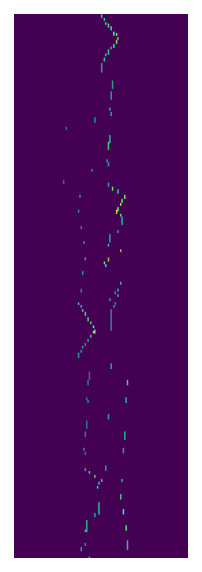

(2, 400, 128)


In [40]:
x = dataset_6[3][0]
x_vis = x[1,:,:].unsqueeze(0)
Exp.utils.show_img([Exp.utils.deprocessing(x_vis.permute(0,2,1).numpy())])

x = x.numpy()
print (x.shape)

Local explanation requires an instance and the wrapped model.

In [52]:
Exp.local_explanations(x,wm,name='LE_6v2')

The last line in each explanation reports the real model's prediction and how much those predictions are displayed by this explanation. Here Total contribution is the score of restructed feature map from the reduced feature maps.

In [45]:
from IPython.display import HTML, display, Image
import os
from pathlib import Path

#@title { display-mode: "form", run: "auto" }

fpath = Path('Explainers').absolute() / title / 'explanations' / 'all'
imgfile = 'LE_6_0.jpg' #@param ['LE_3_0.jpg', 'LE_3_1.jpg']

display(Image(str(fpath/imgfile)))


FileNotFoundError: No such file or directory: '/share/home/francesco/InvertibleCE/music_experiments/Explainers/ConcComp_layer4_5_[6_12]/explanations/all/LE_6_0.jpg'

FileNotFoundError: No such file or directory: '/share/home/francesco/InvertibleCE/music_experiments/Explainers/ConcComp_layer4_5_[6_12]/explanations/all/LE_6_0.jpg'

<IPython.core.display.Image object>